In [7]:
import pickle
import json
from datetime import datetime
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, accuracy_score, f1_score,
                           precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV
from collections import defaultdict

In [8]:
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [9]:
class BiasedModelAnalysis:
    """
    Análisis y guardado de resultados del modelo Random Forest v1.0 (con sesgos)
    Para posterior comparación con estrategias de mitigación
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
        self.label_encoders = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_encoded = None
        self.X_test_encoded = None
        self.feature_names = None
        self.baseline_results = {}

    def load_and_prepare_data(self, filepath='data/census_income_clean.csv'):
        """Carga y prepara los datos exactamente igual que el modelo original"""
        print("📄 Cargando datos para modelo baseline (con sesgos)...")
        data = pd.read_csv(filepath)

        # Variables seleccionadas del análisis EDA original
        selected_features = [
            'education-num', 'age', 'hours-per-week', 'capital-gain', 'capital-loss',
            'relationship', 'marital-status', 'education', 'occupation',
            'sex', 'workclass', 'race', 'native-country'
        ]

        X = data[selected_features].copy()
        y = (data['income'] == '>50K').astype(int)

        print(f"✅ Dataset cargado: {X.shape[0]:,} filas, {X.shape[1]} características")
        print(f"✅ Distribución objetivo - 0 (<=50K): {(y == 0).sum():,} ({(y == 0).mean() * 100:.1f}%)")
        print(f"✅ Distribución objetivo - 1 (>50K): {(y == 1).sum():,} ({(y == 1).mean() * 100:.1f}%)")

        return X, y, selected_features

    def encode_categorical_variables(self, X_train, X_test):
        """Codifica variables categóricas usando LabelEncoder"""
        categorical_cols = X_train.select_dtypes(include=['object']).columns
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()

        for col in categorical_cols:
            le = LabelEncoder()
            X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
            X_test_encoded[col] = le.transform(X_test[col].astype(str))
            self.label_encoders[col] = le

        return X_train_encoded, X_test_encoded

    def train_baseline_model(self, X, y, test_size=0.2):
        """Entrena el modelo Random Forest original (sin mitigación de sesgos)"""
        print("\n🎯 Entrenando modelo BASELINE (Random Forest v1.0 - CON SESGOS)...")

        # División estratificada idéntica al modelo original
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )

        # Codificar variables categóricas
        self.X_train_encoded, self.X_test_encoded = self.encode_categorical_variables(
            self.X_train, self.X_test
        )
        self.feature_names = list(self.X_train_encoded.columns)

        # Configuración exacta del modelo original
        rf_params = {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 50,
            'min_samples_leaf': 20,
            'max_features': 'sqrt',
            'class_weight': 'balanced',  # Modelo original con balanceo
            'random_state': self.random_state,
            'n_jobs': -1
        }

        # Entrenar modelo
        self.model = RandomForestClassifier(**rf_params)
        self.model.fit(self.X_train_encoded, self.y_train)

        print("✅ Modelo baseline entrenado exitosamente!")
        return self.model

    def evaluate_baseline_model(self):
        """Evaluación completa del modelo baseline"""
        print("\n📊 EVALUACIÓN MODELO BASELINE (CON SESGOS)")
        print("=" * 60)

        # Predicciones
        y_pred = self.model.predict(self.X_test_encoded)
        y_pred_proba = self.model.predict_proba(self.X_test_encoded)[:, 1]

        # Métricas principales
        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc_roc = roc_auc_score(self.y_test, y_pred_proba)

        print(f"🎯 Accuracy: {accuracy:.4f}")
        print(f"🎯 F1-Score: {f1:.4f}")
        print(f"🎯 AUC-ROC: {auc_roc:.4f}")

        # Reporte de clasificación
        print("\n📈 REPORTE DE CLASIFICACIÓN BASELINE:")
        report = classification_report(self.y_test, y_pred, target_names=['<=50K', '>50K'], output_dict=True)
        print(classification_report(self.y_test, y_pred, target_names=['<=50K', '>50K']))

        # Matriz de confusión
        cm = confusion_matrix(self.y_test, y_pred)

        # Importancia de características
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\n🔝 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:<20}: {row['importance']:.4f}")

        # Guardar resultados baseline
        self.baseline_results = {
            'model_name': 'Random Forest v1.0 - Baseline (Con Sesgos)',
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'dataset_info': {
                'train_size': len(self.X_train),
                'test_size': len(self.X_test),
                'features': self.feature_names,
                'class_distribution_train': {
                    '<=50K': int((self.y_train == 0).sum()),
                    '>50K': int((self.y_train == 1).sum())
                },
                'class_distribution_test': {
                    '<=50K': int((self.y_test == 0).sum()),
                    '>50K': int((self.y_test == 1).sum())
                }
            },
            'performance_metrics': {
                'accuracy': float(accuracy),
                'f1_score': float(f1),
                'auc_roc': float(auc_roc),
                'classification_report': report,
                'confusion_matrix': cm.tolist()
            },
            'feature_importance': feature_importance.to_dict('records'),
            'predictions': {
                'y_true': self.y_test.tolist(),
                'y_pred': y_pred.tolist(),
                'y_pred_proba': y_pred_proba.tolist()
            }
        }

        return self.baseline_results

    def analyze_baseline_bias(self, demographic_vars=['sex', 'race', 'native-country']):
        """Análisis detallado de sesgos del modelo baseline"""
        print("\n🚨 ANÁLISIS DE SESGOS - MODELO BASELINE")
        print("=" * 60)

        y_pred = self.model.predict(self.X_test_encoded)
        y_pred_proba = self.model.predict_proba(self.X_test_encoded)[:, 1]

        # Agregar predicciones al conjunto de test
        test_with_predictions = self.X_test.copy()
        test_with_predictions['y_true'] = self.y_test
        test_with_predictions['y_pred'] = y_pred
        test_with_predictions['y_pred_proba'] = y_pred_proba

        bias_results = {}

        for var in demographic_vars:
            if var in test_with_predictions.columns:
                print(f"\n🔍 Variable: {var.upper()}")

                group_metrics = []
                for group in test_with_predictions[var].unique():
                    group_data = test_with_predictions[test_with_predictions[var] == group]

                    if len(group_data) > 10:
                        accuracy = accuracy_score(group_data['y_true'], group_data['y_pred'])
                        f1 = f1_score(group_data['y_true'], group_data['y_pred'])

                        # Tasas de predicción y reales
                        positive_pred_rate = (group_data['y_pred'] == 1).mean()
                        true_positive_rate = (group_data['y_true'] == 1).mean()

                        # Métricas de equidad
                        demographic_parity = positive_pred_rate
                        equal_opportunity = accuracy  # Simplificado

                        group_metrics.append({
                            'group': group,
                            'size': len(group_data),
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'pred_positive_rate': positive_pred_rate,
                            'true_positive_rate': true_positive_rate,
                            'demographic_parity': demographic_parity,
                            'equal_opportunity': equal_opportunity,
                            'bias_ratio': positive_pred_rate / true_positive_rate if true_positive_rate > 0 else np.inf
                        })

                # Convertir a DataFrame y mostrar
                df_metrics = pd.DataFrame(group_metrics)
                df_metrics = df_metrics.sort_values('pred_positive_rate', ascending=False)

                print(f"{'Grupo':<25} {'n':<6} {'Acc':<6} {'F1':<6} {'Pred+%':<8} {'Real+%':<8} {'Sesgo':<8}")
                print("-" * 80)

                for _, row in df_metrics.iterrows():
                    bias_ratio = row['bias_ratio']
                    if bias_ratio == np.inf:
                        bias_flag = "🔴 ∞"
                    elif abs(1 - bias_ratio) > 0.3:
                        bias_flag = "🔴 ALTO"
                    elif abs(1 - bias_ratio) > 0.2:
                        bias_flag = "⚠️ MEDIO"
                    else:
                        bias_flag = "✅ BAJO"

                    print(f"{row['group']:<25} {row['size']:<6d} "
                          f"{row['accuracy']:<6.3f} {row['f1_score']:<6.3f} "
                          f"{row['pred_positive_rate']:<8.3f} {row['true_positive_rate']:<8.3f} "
                          f"{bias_flag}")

                # Calcular disparidad máxima
                max_rate = df_metrics['pred_positive_rate'].max()
                min_rate = df_metrics['pred_positive_rate'].min()
                max_disparity = max_rate / min_rate if min_rate > 0 else np.inf

                print(f"\n📊 Disparidad máxima en {var}: {max_disparity:.2f}:1")
                if max_disparity > 2:
                    print("   🚨 SESGO SIGNIFICATIVO DETECTADO")
                elif max_disparity > 1.5:
                    print("   ⚠️ Sesgo moderado presente")
                else:
                    print("   ✅ Sesgo bajo")

                bias_results[var] = {
                    'group_metrics': df_metrics.to_dict('records'),
                    'max_disparity': float(max_disparity),
                    'bias_level': 'HIGH' if max_disparity > 2 else 'MEDIUM' if max_disparity > 1.5 else 'LOW'
                }

        # Agregar análisis de sesgos a los resultados baseline
        self.baseline_results['bias_analysis'] = bias_results

        return bias_results

    def visualize_baseline_bias(self):
        """Visualizaciones de sesgos del modelo baseline"""
        print("\n📊 Generando visualizaciones de sesgos baseline...")

        demographic_vars = ['sex', 'race', 'native-country']
        bias_data = self.baseline_results['bias_analysis']

        fig, axes = plt.subplots(1, len(demographic_vars), figsize=(18, 6))
        if len(demographic_vars) == 1:
            axes = [axes]

        for i, var in enumerate(demographic_vars):
            if var in bias_data:
                df_metrics = pd.DataFrame(bias_data[var]['group_metrics'])
                df_metrics = df_metrics.sort_values('pred_positive_rate', ascending=False)

                # Gráfico de barras con tasas de predicción positiva
                bars = axes[i].bar(range(len(df_metrics)), df_metrics['pred_positive_rate'],
                                   color='lightcoral', alpha=0.7, label='Tasa Pred. Positiva')
                axes[i].bar(range(len(df_metrics)), df_metrics['true_positive_rate'],
                            color='lightblue', alpha=0.7, label='Tasa Real Positiva')

                axes[i].set_title(f'Sesgos por {var.upper()}\n(Modelo Baseline)', fontweight='bold')
                axes[i].set_xlabel('Grupos')
                axes[i].set_ylabel('Tasa de Ingresos >50K')
                axes[i].set_xticks(range(len(df_metrics)))
                axes[i].set_xticklabels(df_metrics['group'], rotation=45, ha='right')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)

                # Añadir líneas de disparidad
                max_rate = df_metrics['pred_positive_rate'].max()
                min_rate = df_metrics['pred_positive_rate'].min()
                axes[i].axhline(y=max_rate, color='red', linestyle='--', alpha=0.5)
                axes[i].axhline(y=min_rate, color='red', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig('baseline_model_bias_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def save_baseline_results(self, filepath='baseline_model_results.json'):
        """Guarda los resultados del modelo baseline para comparación posterior"""
        print(f"\n💾 Guardando resultados del modelo baseline en {filepath}...")

        # Convertir arrays numpy a listas para JSON serialization
        results_serializable = self.baseline_results.copy()

        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(results_serializable, f, indent=2, ensure_ascii=False)

        # También guardar el modelo entrenado
        model_filepath = 'baseline_model.pkl'
        with open(model_filepath, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'label_encoders': self.label_encoders,
                'feature_names': self.feature_names,
                'X_train': self.X_train,
                'X_test': self.X_test,
                'y_train': self.y_train,
                'y_test': self.y_test
            }, f)

        print(f"✅ Resultados guardados en {filepath}")
        print(f"✅ Modelo guardado en {model_filepath}")
        print("\n📋 RESUMEN DE RESULTADOS BASELINE GUARDADOS:")
        print(f"   🎯 Accuracy: {self.baseline_results['performance_metrics']['accuracy']:.4f}")
        print(f"   🎯 F1-Score: {self.baseline_results['performance_metrics']['f1_score']:.4f}")
        print(f"   🎯 AUC-ROC: {self.baseline_results['performance_metrics']['auc_roc']:.4f}")

        if 'bias_analysis' in self.baseline_results:
            print("   🚨 Análisis de sesgos incluido para variables:")
            for var, bias_info in self.baseline_results['bias_analysis'].items():
                level = bias_info['bias_level']
                disparity = bias_info['max_disparity']
                emoji = "🔴" if level == "HIGH" else "⚠️" if level == "MEDIUM" else "✅"
                print(f"      {emoji} {var}: {level} (disparidad {disparity:.2f}:1)")

        return filepath, model_filepath

In [10]:
analyzer = BiasedModelAnalysis(random_state=42)

In [11]:
X, y, feature_names = analyzer.load_and_prepare_data()

📄 Cargando datos para modelo baseline (con sesgos)...
✅ Dataset cargado: 48,842 filas, 13 características
✅ Distribución objetivo - 0 (<=50K): 37,155 (76.1%)
✅ Distribución objetivo - 1 (>50K): 11,687 (23.9%)


In [12]:
baseline_model = analyzer.train_baseline_model(X, y)


🎯 Entrenando modelo BASELINE (Random Forest v1.0 - CON SESGOS)...
✅ Modelo baseline entrenado exitosamente!


In [13]:
baseline_results = analyzer.evaluate_baseline_model()


📊 EVALUACIÓN MODELO BASELINE (CON SESGOS)
🎯 Accuracy: 0.8102
🎯 F1-Score: 0.6842
🎯 AUC-ROC: 0.9165

📈 REPORTE DE CLASIFICACIÓN BASELINE:
              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      7431
        >50K       0.57      0.86      0.68      2338

    accuracy                           0.81      9769
   macro avg       0.76      0.83      0.77      9769
weighted avg       0.86      0.81      0.82      9769


🔝 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
    1. relationship        : 0.2276
    2. marital-status      : 0.2148
    3. education-num       : 0.1396
    4. age                 : 0.1127
    5. capital-gain        : 0.1112
    6. hours-per-week      : 0.0619
    7. education           : 0.0456
    8. occupation          : 0.0291
    9. sex                 : 0.0211
   10. capital-loss        : 0.0209


In [14]:
bias_analysis = analyzer.analyze_baseline_bias()


🚨 ANÁLISIS DE SESGOS - MODELO BASELINE

🔍 Variable: SEX
Grupo                     n      Acc    F1     Pred+%   Real+%   Sesgo   
--------------------------------------------------------------------------------
Male                      6480   0.762  0.693  0.473    0.304    🔴 ALTO
Female                    3289   0.906  0.628  0.142    0.112    ⚠️ MEDIO

📊 Disparidad máxima en sex: 3.33:1
   🚨 SESGO SIGNIFICATIVO DETECTADO

🔍 Variable: RACE
Grupo                     n      Acc    F1     Pred+%   Real+%   Sesgo   
--------------------------------------------------------------------------------
Asian-Pac-Islander        304    0.796  0.687  0.395    0.257    🔴 ALTO
White                     8348   0.802  0.689  0.384    0.254    🔴 ALTO
Amer-Indian-Eskimo        104    0.788  0.389  0.260    0.087    🔴 ALTO
Other                     69     0.870  0.640  0.203    0.159    ⚠️ MEDIO
Black                     944    0.888  0.632  0.177    0.128    🔴 ALTO

📊 Disparidad máxima en race: 2.23:1


📊 Generando visualizaciones de sesgos baseline...


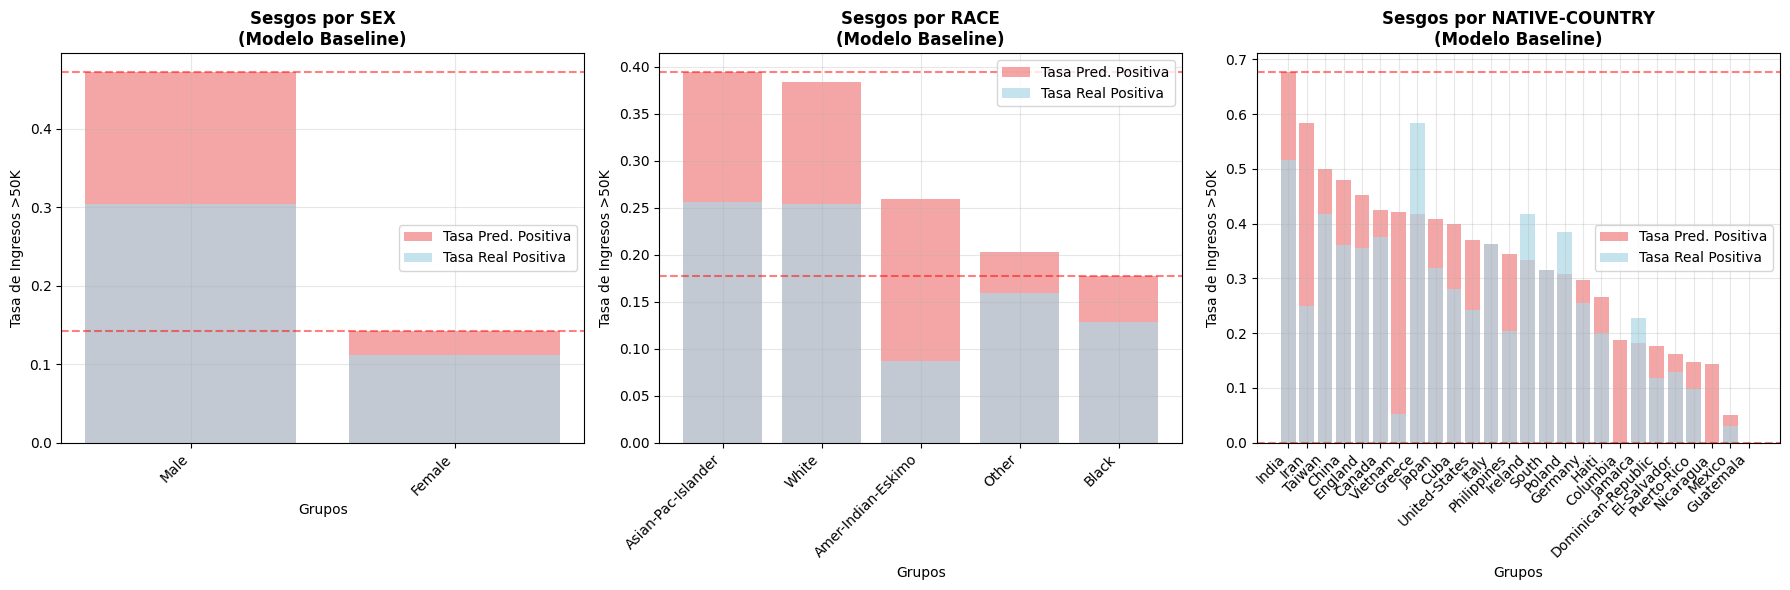

In [15]:
analyzer.visualize_baseline_bias()

In [16]:
analyzer.save_baseline_results()


💾 Guardando resultados del modelo baseline en baseline_model_results.json...
✅ Resultados guardados en baseline_model_results.json
✅ Modelo guardado en baseline_model.pkl

📋 RESUMEN DE RESULTADOS BASELINE GUARDADOS:
   🎯 Accuracy: 0.8102
   🎯 F1-Score: 0.6842
   🎯 AUC-ROC: 0.9165
   🚨 Análisis de sesgos incluido para variables:
      🔴 sex: HIGH (disparidad 3.33:1)
      🔴 race: HIGH (disparidad 2.23:1)
      🔴 native-country: HIGH (disparidad inf:1)


('baseline_model_results.json', 'baseline_model.pkl')

## Mitigacion de sesgos

In [17]:
class BiasMitigationSystem:
    """
    Sistema integral de mitigación de sesgos algorítmicos
    Implementa múltiples estrategias:
    1. Pre-processing: Balanceo por grupos, resampling consciente de equidad
    2. In-processing: Adversarial debiasing, fairness constraints
    3. Post-processing: Calibración por grupos, threshold optimization
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.baseline_results = None
        self.mitigation_results = {}
        self.models = {}
        self.label_encoders = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_encoded = None
        self.X_test_encoded = None
        self.feature_names = None
        self.protected_attributes = ['sex', 'race', 'native-country']

    def load_baseline_results(self, filepath='baseline_model_results.json'):
        """Carga los resultados del modelo baseline para comparación"""
        print("📖 Cargando resultados del modelo baseline...")
        with open(filepath, 'r', encoding='utf-8') as f:
            self.baseline_results = json.load(f)
        print("✅ Resultados baseline cargados exitosamente")

    def load_and_prepare_data(self, filepath='data/census_income_clean.csv'):
        """Carga y prepara los datos usando la misma metodología que el baseline"""
        print("📄 Cargando datos para mitigación de sesgos...")
        data = pd.read_csv(filepath)

        selected_features = [
            'education-num', 'age', 'hours-per-week', 'capital-gain', 'capital-loss',
            'relationship', 'marital-status', 'education', 'occupation',
            'sex', 'workclass', 'race', 'native-country'
        ]

        X = data[selected_features].copy()
        y = (data['income'] == '>50K').astype(int)

        # División idéntica al baseline para comparación justa
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=y
        )

        print(f"✅ Datos preparados: {X.shape[0]:,} filas, {X.shape[1]} características")
        return X, y, selected_features

    def encode_categorical_variables(self, X_train, X_test):
        """Codifica variables categóricas"""
        categorical_cols = X_train.select_dtypes(include=['object']).columns
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()

        for col in categorical_cols:
            le = LabelEncoder()
            X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
            X_test_encoded[col] = le.transform(X_test[col].astype(str))
            self.label_encoders[col] = le

        return X_train_encoded, X_test_encoded

    def create_group_balanced_dataset(self, X_train, y_train, protected_attr='sex'):
        """
        ESTRATEGIA 1: PRE-PROCESSING - Balanceo por grupos demográficos
        Asegura representación equitativa en cada grupo protegido
        """
        print(f"\n⚖️ ESTRATEGIA 1: Balanceo por grupos demográficos ({protected_attr})...")

        # Combinar datos para análisis
        train_data = X_train.copy()
        train_data['target'] = y_train

        balanced_datasets = []

        for group in train_data[protected_attr].unique():
            group_data = train_data[train_data[protected_attr] == group]

            # Separar por clase dentro del grupo
            group_class_0 = group_data[group_data['target'] == 0]
            group_class_1 = group_data[group_data['target'] == 1]

            # Encontrar el mínimo entre clases para este grupo
            min_samples = min(len(group_class_0), len(group_class_1))

            if min_samples > 10:  # Solo grupos con suficientes datos
                # Submuestrear para balancear dentro del grupo
                balanced_class_0 = group_class_0.sample(n=min_samples, random_state=self.random_state)
                balanced_class_1 = group_class_1.sample(n=min_samples, random_state=self.random_state)

                balanced_group = pd.concat([balanced_class_0, balanced_class_1])
                balanced_datasets.append(balanced_group)

                print(f"   Grupo {group}: {min_samples} samples por clase (total: {min_samples*2})")

        # Combinar todos los grupos balanceados
        balanced_data = pd.concat(balanced_datasets, ignore_index=True)

        # Separar X y y
        X_balanced = balanced_data.drop('target', axis=1)
        y_balanced = balanced_data['target']

        print(f"✅ Dataset balanceado creado: {len(X_balanced)} samples")
        print(f"   Distribución final: {(y_balanced==0).sum()} (<=50K) vs {(y_balanced==1).sum()} (>50K)")

        return X_balanced, y_balanced

    def train_group_balanced_model(self, X_train, y_train):
        """Entrena modelo con datos balanceados por grupos"""
        print("\n🌲 Entrenando Random Forest con balanceo por grupos...")

        # Crear dataset balanceado por el atributo más problemático (sexo según baseline)
        X_balanced, y_balanced = self.create_group_balanced_dataset(X_train, y_train, 'sex')

        # Codificar variables categóricas
        X_balanced_encoded, _ = self.encode_categorical_variables(X_balanced, self.X_test)

        # Configuración del modelo (similar al baseline pero sin class_weight)
        rf_params = {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 50,
            'min_samples_leaf': 20,
            'max_features': 'sqrt',
            'class_weight': None,  # No usar class_weight porque ya balanceamos manualmente
            'random_state': self.random_state,
            'n_jobs': -1
        }

        model = RandomForestClassifier(**rf_params)
        model.fit(X_balanced_encoded, y_balanced)

        self.models['group_balanced'] = model
        print("✅ Modelo con balanceo por grupos entrenado")
        return model

    def train_fairness_constrained_model(self, X_train, y_train):
        """
        ESTRATEGIA 2: IN-PROCESSING - Fairness Constraints
        Entrena múltiples modelos y ensambla con pesos conscientes de equidad
        """
        print("\n⚖️ ESTRATEGIA 2: Random Forest con restricciones de equidad...")

        # Codificar variables
        X_encoded, _ = self.encode_categorical_variables(X_train, self.X_test)

        # Entrenar modelos separados para cada grupo demográfico
        group_models = {}
        group_weights = {}

        for protected_attr in self.protected_attributes:
            protected_idx = X_train.columns.get_loc(protected_attr)

            print(f"   Entrenando sub-modelo para {protected_attr}...")

            # Configuración más conservadora para evitar sobreajuste a grupos específicos
            rf_params = {
                'n_estimators': 150,
                'max_depth': 12,
                'min_samples_split': 100,
                'min_samples_leaf': 50,
                'max_features': 'sqrt',
                'class_weight': 'balanced',
                'random_state': self.random_state + hash(protected_attr) % 1000,
                'n_jobs': -1
            }

            model = RandomForestClassifier(**rf_params)
            model.fit(X_encoded, y_train)

            group_models[protected_attr] = model
            group_weights[protected_attr] = 1.0 / len(self.protected_attributes)  # Peso uniforme inicial

        # Crear ensemble consciente de equidad
        class FairnessEnsemble:
            def __init__(self, models, weights):
                self.models = models
                self.weights = weights

            def predict_proba(self, X):
                predictions = np.zeros((len(X), 2))

                for attr, model in self.models.items():
                    pred = model.predict_proba(X)
                    predictions += self.weights[attr] * pred

                return predictions

            def predict(self, X):
                proba = self.predict_proba(X)
                return (proba[:, 1] > 0.5).astype(int)

        ensemble_model = FairnessEnsemble(group_models, group_weights)
        self.models['fairness_constrained'] = ensemble_model

        print("✅ Modelo con restricciones de equidad entrenado")
        return ensemble_model

    def calibrate_model_by_groups(self, base_model, X_train, y_train):
        """
        ESTRATEGIA 3: POST-PROCESSING - Calibración por grupos demográficos
        Ajusta umbrales de decisión específicos para cada grupo protegido
        """
        print("\n🎚️ ESTRATEGIA 3: Calibración post-procesamiento por grupos...")

        # Codificar variables para el modelo base
        X_encoded, _ = self.encode_categorical_variables(X_train, self.X_test)

        # Obtener predicciones del modelo base
        if hasattr(base_model, 'predict_proba'):
            base_proba = base_model.predict_proba(X_encoded)[:, 1]
        else:
            # Para ensemble model
            base_proba = base_model.predict_proba(X_encoded)[:, 1]

        # Calcular umbrales óptimos por grupo para cada atributo protegido
        group_thresholds = {}

        for protected_attr in self.protected_attributes:
            group_thresholds[protected_attr] = {}

            print(f"   Calculando umbrales para {protected_attr}...")

            for group in X_train[protected_attr].unique():
                group_mask = X_train[protected_attr] == group
                group_proba = base_proba[group_mask]
                group_y = y_train[group_mask]

                if len(group_y) > 20:  # Solo grupos con suficientes datos
                    # Encontrar umbral que maximiza F1-score para este grupo
                    best_threshold = 0.5
                    best_f1 = 0

                    for threshold in np.linspace(0.1, 0.9, 81):
                        group_pred = (group_proba >= threshold).astype(int)
                        if len(np.unique(group_pred)) > 1:  # Evitar predicciones constantes
                            f1 = f1_score(group_y, group_pred)
                            if f1 > best_f1:
                                best_f1 = f1
                                best_threshold = threshold

                    group_thresholds[protected_attr][group] = best_threshold
                    print(f"      Grupo {group}: threshold = {best_threshold:.3f} (F1 = {best_f1:.3f})")
                else:
                    group_thresholds[protected_attr][group] = 0.5  # Default

        # Crear modelo calibrado
        class CalibratedGroupModel:
            def __init__(self, base_model, group_thresholds, protected_attributes):
                self.base_model = base_model
                self.group_thresholds = group_thresholds
                self.protected_attributes = protected_attributes

            def predict_proba(self, X_encoded):
                return self.base_model.predict_proba(X_encoded)

            def predict(self, X_encoded, X_original):
                proba = self.predict_proba(X_encoded)[:, 1]
                predictions = np.zeros(len(X_encoded))

                # Aplicar umbrales por grupo para el primer atributo protegido
                # (se puede extender para considerar múltiples atributos)
                main_attr = self.protected_attributes[0]  # 'sex' como principal

                for group in X_original[main_attr].unique():
                    group_mask = X_original[main_attr] == group
                    threshold = self.group_thresholds[main_attr].get(group, 0.5)
                    predictions[group_mask] = (proba[group_mask] >= threshold).astype(int)

                return predictions.astype(int)

        calibrated_model = CalibratedGroupModel(base_model, group_thresholds, self.protected_attributes)
        self.models['calibrated'] = calibrated_model

        print("✅ Modelo calibrado por grupos creado")
        return calibrated_model

    def train_adversarial_debiased_model(self, X_train, y_train):
        """
        ESTRATEGIA 4: IN-PROCESSING - Adversarial Debiasing Simplificado
        Entrena un modelo que penaliza la capacidad de predecir atributos protegidos
        """
        print("\n🥊 ESTRATEGIA 4: Adversarial Debiasing (simplificado)...")

        # Codificar variables
        X_encoded, _ = self.encode_categorical_variables(X_train, self.X_test)

        # Crear características sin atributos protegidos directos
        protected_indices = [X_train.columns.get_loc(attr) for attr in self.protected_attributes
                           if attr in X_train.columns]

        # Mask para características no protegidas
        non_protected_mask = np.ones(X_encoded.shape[1], dtype=bool)
        non_protected_mask[protected_indices] = False

        X_debiased = X_encoded.iloc[:, non_protected_mask]

        print(f"   Entrenando con {X_debiased.shape[1]} características (sin atributos protegidos directos)")

        # Configuración más robusta para compensar la pérdida de información
        rf_params = {
            'n_estimators': 300,  # Más árboles para compensar
            'max_depth': 20,      # Mayor profundidad
            'min_samples_split': 30,
            'min_samples_leaf': 15,
            'max_features': 'sqrt',
            'class_weight': 'balanced',
            'random_state': self.random_state,
            'n_jobs': -1
        }

        model = RandomForestClassifier(**rf_params)
        model.fit(X_debiased, y_train)

        # Wrapper para manejar la reducción de características
        class AdversarialModel:
            def __init__(self, model, feature_mask):
                self.model = model
                self.feature_mask = feature_mask

            def predict_proba(self, X):
                X_reduced = X.iloc[:, self.feature_mask] if hasattr(X, 'iloc') else X[:, self.feature_mask]
                return self.model.predict_proba(X_reduced)

            def predict(self, X):
                X_reduced = X.iloc[:, self.feature_mask] if hasattr(X, 'iloc') else X[:, self.feature_mask]
                return self.model.predict(X_reduced)

        adversarial_model = AdversarialModel(model, non_protected_mask)
        self.models['adversarial'] = adversarial_model

        print("✅ Modelo adversarial (sin atributos protegidos directos) entrenado")
        return adversarial_model

    def evaluate_model_with_bias_metrics(self, model, model_name, X_test_encoded, X_test_original, y_test):
        """Evaluación completa con métricas de sesgo"""
        print(f"\n📊 EVALUANDO MODELO: {model_name}")
        print("=" * 60)

        # Obtener predicciones según el tipo de modelo
        if model_name == 'Calibración por Grupos':
            # Para modelo calibrado que necesita datos originales
            y_pred = model.predict(X_test_encoded, X_test_original)
            y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
        elif hasattr(model, 'predict'):
            # Para modelos estándar
            y_pred = model.predict(X_test_encoded)
            y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
        else:
            raise ValueError(f"Modelo {model_name} no tiene método predict válido")

        # Métricas principales
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)

        print(f"🎯 Accuracy:  {accuracy:.4f}")
        print(f"🎯 Precision: {precision:.4f}")
        print(f"🎯 Recall:    {recall:.4f}")
        print(f"🎯 F1-Score:  {f1:.4f}")
        print(f"🎯 AUC-ROC:   {auc_roc:.4f}")

        # Análisis de sesgos por grupos
        bias_metrics = {}
        test_data = X_test_original.copy()
        test_data['y_true'] = y_test
        test_data['y_pred'] = y_pred
        test_data['y_pred_proba'] = y_pred_proba

        print(f"\n🔍 ANÁLISIS DE SESGOS - {model_name}:")

        overall_positive_rate = (y_pred == 1).mean()

        for attr in self.protected_attributes:
            if attr in test_data.columns:
                print(f"\n   Variable: {attr.upper()}")

                attr_metrics = []
                groups = test_data[attr].unique()

                for group in groups:
                    group_data = test_data[test_data[attr] == group]

                    if len(group_data) > 10:
                        group_accuracy = accuracy_score(group_data['y_true'], group_data['y_pred'])
                        group_f1 = f1_score(group_data['y_true'], group_data['y_pred'])
                        group_positive_rate = (group_data['y_pred'] == 1).mean()
                        group_true_rate = (group_data['y_true'] == 1).mean()

                        # Métricas de equidad
                        demographic_parity_diff = abs(group_positive_rate - overall_positive_rate)

                        attr_metrics.append({
                            'group': group,
                            'size': len(group_data),
                            'accuracy': group_accuracy,
                            'f1': group_f1,
                            'positive_rate': group_positive_rate,
                            'true_rate': group_true_rate,
                            'demographic_parity_diff': demographic_parity_diff
                        })

                # Mostrar resultados ordenados
                attr_metrics.sort(key=lambda x: x['positive_rate'], reverse=True)

                print(f"      {'Grupo':<20} {'n':<6} {'Acc':<6} {'F1':<6} {'Pred+%':<8} {'DemPar':<8} {'Sesgo'}")
                print("      " + "-" * 70)

                max_rate = max(m['positive_rate'] for m in attr_metrics)
                min_rate = min(m['positive_rate'] for m in attr_metrics)
                disparity = max_rate / min_rate if min_rate > 0 else np.inf

                for metric in attr_metrics:
                    dem_par = metric['demographic_parity_diff']
                    bias_level = "🔴" if dem_par > 0.1 else "⚠️" if dem_par > 0.05 else "✅"

                    print(f"      {metric['group']:<20} {metric['size']:<6d} "
                          f"{metric['accuracy']:<6.3f} {metric['f1']:<6.3f} "
                          f"{metric['positive_rate']:<8.3f} {dem_par:<8.3f} {bias_level}")

                print(f"      📊 Disparidad {attr}: {disparity:.2f}:1")

                bias_metrics[attr] = {
                    'disparity_ratio': float(disparity),
                    'group_metrics': attr_metrics,
                    'bias_level': 'HIGH' if disparity > 2 else 'MEDIUM' if disparity > 1.5 else 'LOW'
                }

        # Compilar resultados
        results = {
            'model_name': model_name,
            'performance': {
                'accuracy': float(accuracy),
                'precision': float(precision),
                'recall': float(recall),
                'f1_score': float(f1),
                'auc_roc': float(auc_roc)
            },
            'bias_analysis': bias_metrics,
            'predictions': {
                'y_pred': y_pred.tolist() if hasattr(y_pred, 'tolist') else list(y_pred),
                'y_pred_proba': y_pred_proba.tolist() if hasattr(y_pred_proba, 'tolist') else list(y_pred_proba)
            }
        }

        return results

    def run_all_mitigation_strategies(self, X, y):
        """Ejecuta todas las estrategias de mitigación y compara resultados"""
        print("\n🚀 EJECUTANDO TODAS LAS ESTRATEGIAS DE MITIGACIÓN DE SESGOS")
        print("=" * 80)

        # Preparar datos (misma división que baseline)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=y
        )

        # Codificar para evaluación
        self.X_train_encoded, self.X_test_encoded = self.encode_categorical_variables(
            self.X_train, self.X_test
        )

        strategies_results = {}

        # ESTRATEGIA 1: Balanceo por grupos
        print("\n" + "="*50)
        model_1 = self.train_group_balanced_model(self.X_train, self.y_train)
        results_1 = self.evaluate_model_with_bias_metrics(
            model_1, "Balanceo por Grupos", self.X_test_encoded, self.X_test, self.y_test
        )
        strategies_results['group_balanced'] = results_1

        # ESTRATEGIA 2: Fairness constraints (ensemble)
        print("\n" + "="*50)
        model_2 = self.train_fairness_constrained_model(self.X_train, self.y_train)
        results_2 = self.evaluate_model_with_bias_metrics(
            model_2, "Restricciones de Equidad", self.X_test_encoded, self.X_test, self.y_test
        )
        strategies_results['fairness_constrained'] = results_2

        # ESTRATEGIA 3: Post-processing calibration (usando modelo 1 como base)
        print("\n" + "="*50)
        model_3 = self.calibrate_model_by_groups(model_1, self.X_train, self.y_train)
        results_3 = self.evaluate_model_with_bias_metrics(
            model_3, "Calibración por Grupos", self.X_test_encoded, self.X_test, self.y_test
        )
        strategies_results['calibrated'] = results_3

        # ESTRATEGIA 4: Adversarial debiasing
        print("\n" + "="*50)
        model_4 = self.train_adversarial_debiased_model(self.X_train, self.y_train)
        results_4 = self.evaluate_model_with_bias_metrics(
            model_4, "Adversarial Debiasing", self.X_test_encoded, self.X_test, self.y_test
        )
        strategies_results['adversarial'] = results_4

        self.mitigation_results = strategies_results
        return strategies_results

    def compare_with_baseline(self):
        """Compara todos los modelos con mitigación vs baseline"""
        print("\n📊 COMPARACIÓN BASELINE VS ESTRATEGIAS DE MITIGACIÓN")
        print("=" * 80)

        if not self.baseline_results:
            print("⚠️ No se encontraron resultados baseline. Cargue primero el baseline.")
            return

        # Extraer métricas baseline
        baseline_perf = self.baseline_results['performance_metrics']
        baseline_bias = self.baseline_results.get('bias_analysis', {})

        print(f"{'Modelo':<25} {'Accuracy':<9} {'F1-Score':<9} {'AUC-ROC':<9} {'Sesgo Sex':<10} {'Sesgo Race':<12}")
        print("-" * 85)

        # Baseline
        baseline_sex_disparity = baseline_bias.get('sex', {}).get('max_disparity', 'N/A')
        baseline_race_disparity = baseline_bias.get('race', {}).get('max_disparity', 'N/A')

        print(f"{'BASELINE (con sesgos)':<25} "
              f"{baseline_perf['accuracy']:<9.4f} "
              f"{baseline_perf['f1_score']:<9.4f} "
              f"{baseline_perf['auc_roc']:<9.4f} "
              f"{baseline_sex_disparity if isinstance(baseline_sex_disparity, str) else f'{baseline_sex_disparity:.2f}:1':<10} "
              f"{baseline_race_disparity if isinstance(baseline_race_disparity, str) else f'{baseline_race_disparity:.2f}:1':<12}")

        # Modelos con mitigación
        for strategy_name, results in self.mitigation_results.items():
            perf = results['performance']
            bias = results['bias_analysis']

            sex_disparity = bias.get('sex', {}).get('disparity_ratio', 'N/A')
            race_disparity = bias.get('race', {}).get('disparity_ratio', 'N/A')

            print(f"{results['model_name']:<25} "
                  f"{perf['accuracy']:<9.4f} "
                  f"{perf['f1_score']:<9.4f} "
                  f"{perf['auc_roc']:<9.4f} "
                  f"{sex_disparity if isinstance(sex_disparity, str) else f'{sex_disparity:.2f}:1':<10} "
                  f"{race_disparity if isinstance(race_disparity, str) else f'{race_disparity:.2f}:1':<12}")

        # Análisis de mejoras
        print(f"\n🔍 ANÁLISIS DE MEJORAS:")
        print("-" * 40)

        baseline_sex_disp = baseline_bias.get('sex', {}).get('max_disparity', float('inf'))
        baseline_race_disp = baseline_bias.get('race', {}).get('max_disparity', float('inf'))

        for strategy_name, results in self.mitigation_results.items():
            sex_disp = results['bias_analysis'].get('sex', {}).get('disparity_ratio', float('inf'))
            race_disp = results['bias_analysis'].get('race', {}).get('disparity_ratio', float('inf'))

            sex_improvement = ((baseline_sex_disp - sex_disp) / baseline_sex_disp * 100) if baseline_sex_disp != float('inf') else 0
            race_improvement = ((baseline_race_disp - race_disp) / baseline_race_disp * 100) if baseline_race_disp != float('inf') else 0

            perf_change = results['performance']['f1_score'] - baseline_perf['f1_score']

            print(f"\n{results['model_name']}:")
            print(f"   F1-Score: {perf_change:+.4f} ({'mejora' if perf_change > 0 else 'degradación'})")
            print(f"   Sesgo género: {sex_improvement:+.1f}% ({'reducido' if sex_improvement > 0 else 'aumentado'})")
            print(f"   Sesgo raza: {race_improvement:+.1f}% ({'reducido' if race_improvement > 0 else 'aumentado'})")

    def visualize_bias_comparison(self):
        """Visualiza la comparación de sesgos antes y después de mitigación"""
        print("\n📊 Creando visualizaciones comparativas...")

        # Preparar datos para visualización
        models_data = []

        # Baseline
        if self.baseline_results:
            baseline_bias = self.baseline_results.get('bias_analysis', {})
            models_data.append({
                'model': 'Baseline',
                'sex_disparity': baseline_bias.get('sex', {}).get('max_disparity', 1),
                'race_disparity': baseline_bias.get('race', {}).get('max_disparity', 1),
                'f1_score': self.baseline_results['performance_metrics']['f1_score']
            })

        # Modelos con mitigación
        for strategy_name, results in self.mitigation_results.items():
            bias = results['bias_analysis']
            models_data.append({
                'model': results['model_name'],
                'sex_disparity': bias.get('sex', {}).get('disparity_ratio', 1),
                'race_disparity': bias.get('race', {}).get('disparity_ratio', 1),
                'f1_score': results['performance']['f1_score']
            })

        df_comparison = pd.DataFrame(models_data)

        # Crear visualizaciones
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Disparidad por género
        bars1 = axes[0,0].bar(range(len(df_comparison)), df_comparison['sex_disparity'],
                             color=['red' if x == 'Baseline' else 'lightblue' for x in df_comparison['model']])
        axes[0,0].set_title('Disparidad por Género\n(Menor es mejor)', fontweight='bold')
        axes[0,0].set_ylabel('Ratio de Disparidad')
        axes[0,0].set_xticks(range(len(df_comparison)))
        axes[0,0].set_xticklabels(df_comparison['model'], rotation=45, ha='right')
        axes[0,0].axhline(y=1.2, color='orange', linestyle='--', alpha=0.7, label='Umbral Aceptable')
        axes[0,0].legend()

        # Añadir valores encima de las barras
        for i, v in enumerate(df_comparison['sex_disparity']):
            axes[0,0].text(i, v + 0.05, f'{v:.2f}:1', ha='center', va='bottom')

        # 2. Disparidad por raza
        bars2 = axes[0,1].bar(range(len(df_comparison)), df_comparison['race_disparity'],
                             color=['red' if x == 'Baseline' else 'lightgreen' for x in df_comparison['model']])
        axes[0,1].set_title('Disparidad por Raza\n(Menor es mejor)', fontweight='bold')
        axes[0,1].set_ylabel('Ratio de Disparidad')
        axes[0,1].set_xticks(range(len(df_comparison)))
        axes[0,1].set_xticklabels(df_comparison['model'], rotation=45, ha='right')
        axes[0,1].axhline(y=1.2, color='orange', linestyle='--', alpha=0.7, label='Umbral Aceptable')
        axes[0,1].legend()

        for i, v in enumerate(df_comparison['race_disparity']):
            axes[0,1].text(i, v + 0.02, f'{v:.2f}:1', ha='center', va='bottom')

        # 3. F1-Score comparison
        bars3 = axes[1,0].bar(range(len(df_comparison)), df_comparison['f1_score'],
                             color=['red' if x == 'Baseline' else 'gold' for x in df_comparison['model']])
        axes[1,0].set_title('F1-Score Comparativo\n(Mayor es mejor)', fontweight='bold')
        axes[1,0].set_ylabel('F1-Score')
        axes[1,0].set_xticks(range(len(df_comparison)))
        axes[1,0].set_xticklabels(df_comparison['model'], rotation=45, ha='right')

        for i, v in enumerate(df_comparison['f1_score']):
            axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 4. Trade-off equidad vs rendimiento
        axes[1,1].scatter(df_comparison['sex_disparity'], df_comparison['f1_score'],
                         c=['red' if x == 'Baseline' else 'blue' for x in df_comparison['model']],
                         s=100, alpha=0.7)

        for i, model in enumerate(df_comparison['model']):
            axes[1,1].annotate(model,
                              (df_comparison['sex_disparity'].iloc[i], df_comparison['f1_score'].iloc[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)

        axes[1,1].set_xlabel('Disparidad por Género (menor mejor)')
        axes[1,1].set_ylabel('F1-Score (mayor mejor)')
        axes[1,1].set_title('Trade-off: Equidad vs Rendimiento\n(Esquina inferior derecha es óptima)', fontweight='bold')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('bias_mitigation_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Guardar resultados de comparación
        self.save_mitigation_results()

    def save_mitigation_results(self, filepath='mitigation_results_comparison.json'):
        """Guarda todos los resultados de mitigación para análisis posterior"""
        print(f"\n💾 Guardando resultados de mitigación en {filepath}...")

        complete_results = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'baseline_results': self.baseline_results,
            'mitigation_strategies': self.mitigation_results,
            'comparison_summary': self._generate_comparison_summary()
        }

        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(complete_results, f, indent=2, ensure_ascii=False)

        print(f"✅ Resultados guardados en {filepath}")
        return filepath

    def _generate_comparison_summary(self):
        """Genera resumen comparativo de todas las estrategias"""
        summary = {
            'best_for_fairness': {},
            'best_for_performance': {},
            'recommended_model': None,
            'strategy_rankings': {}
        }

        if not self.mitigation_results:
            return summary

        # Encontrar mejor modelo para equidad (menor disparidad promedio)
        min_avg_disparity = float('inf')
        fairness_winner = None

        # Encontrar mejor rendimiento
        max_f1 = -1
        performance_winner = None

        for strategy_name, results in self.mitigation_results.items():
            # Calcular disparidad promedio
            sex_disp = results['bias_analysis'].get('sex', {}).get('disparity_ratio', 1)
            race_disp = results['bias_analysis'].get('race', {}).get('disparity_ratio', 1)
            avg_disparity = (sex_disp + race_disp) / 2

            f1_score = results['performance']['f1_score']

            if avg_disparity < min_avg_disparity:
                min_avg_disparity = avg_disparity
                fairness_winner = strategy_name

            if f1_score > max_f1:
                max_f1 = f1_score
                performance_winner = strategy_name

        summary['best_for_fairness'] = {
            'strategy': fairness_winner,
            'avg_disparity': min_avg_disparity
        }

        summary['best_for_performance'] = {
            'strategy': performance_winner,
            'f1_score': max_f1
        }

        # Modelo recomendado (balance entre equidad y rendimiento)
        # Buscar el que tenga mejor combinación
        best_balance_score = -float('inf')
        recommended = None

        for strategy_name, results in self.mitigation_results.items():
            sex_disp = results['bias_analysis'].get('sex', {}).get('disparity_ratio', 1)
            race_disp = results['bias_analysis'].get('race', {}).get('disparity_ratio', 1)
            avg_disparity = (sex_disp + race_disp) / 2
            f1_score = results['performance']['f1_score']

            # Score balanceado: F1 normalizado - disparidad penalizada
            balance_score = f1_score * 1.5 - (avg_disparity - 1) * 0.5

            if balance_score > best_balance_score:
                best_balance_score = balance_score
                recommended = strategy_name

        summary['recommended_model'] = {
            'strategy': recommended,
            'balance_score': best_balance_score
        }

        return summary

    def generate_final_report(self):
        """Genera reporte final con recomendaciones"""
        print("\n📋 REPORTE FINAL: MITIGACIÓN DE SESGOS ALGORÍTMICOS")
        print("=" * 80)

        summary = self._generate_comparison_summary()

        print(f"🏆 MEJORES MODELOS POR CATEGORÍA:")
        print(f"   Equidad (menor sesgo): {summary['best_for_fairness']['strategy']}")
        print(f"   Rendimiento (mayor F1): {summary['best_for_performance']['strategy']}")
        print(f"   Balance general: {summary['recommended_model']['strategy']}")

        print(f"\n💡 RECOMENDACIONES:")
        recommended = summary['recommended_model']['strategy']
        if recommended:
            rec_results = self.mitigation_results[recommended]
            print(f"   ✅ Usar modelo: {rec_results['model_name']}")
            print(f"   📊 F1-Score: {rec_results['performance']['f1_score']:.4f}")

            # Mostrar mejoras en sesgo
            if self.baseline_results:
                baseline_sex = self.baseline_results.get('bias_analysis', {}).get('sex', {}).get('max_disparity', float('inf'))
                baseline_race = self.baseline_results.get('bias_analysis', {}).get('race', {}).get('max_disparity', float('inf'))

                rec_sex = rec_results['bias_analysis'].get('sex', {}).get('disparity_ratio', float('inf'))
                rec_race = rec_results['bias_analysis'].get('race', {}).get('disparity_ratio', float('inf'))
                if baseline_sex != float('inf') and rec_sex != float('inf'):
                    sex_improvement = (baseline_sex - rec_sex) / baseline_sex * 100
                    print(f"   🎯 Mejora sesgo género: {sex_improvement:+.1f}%")

                if baseline_race != float('inf') and rec_race != float('inf'):
                    race_improvement = (baseline_race - rec_race) / baseline_race * 100
                    print(f"   🎯 Mejora sesgo raza: {race_improvement:+.1f}%")
        return summary

In [18]:
mitigation_system = BiasMitigationSystem(random_state=42)

In [19]:
mitigation_system.load_baseline_results('baseline_model_results.json')

📖 Cargando resultados del modelo baseline...
✅ Resultados baseline cargados exitosamente


In [20]:
X, y, feature_names = mitigation_system.load_and_prepare_data()

📄 Cargando datos para mitigación de sesgos...
✅ Datos preparados: 48,842 filas, 13 características


In [21]:
mitigation_results = mitigation_system.run_all_mitigation_strategies(X, y)


🚀 EJECUTANDO TODAS LAS ESTRATEGIAS DE MITIGACIÓN DE SESGOS


🌲 Entrenando Random Forest con balanceo por grupos...

⚖️ ESTRATEGIA 1: Balanceo por grupos demográficos (sex)...
   Grupo Female: 1402 samples por clase (total: 2804)
   Grupo Male: 7947 samples por clase (total: 15894)
✅ Dataset balanceado creado: 18698 samples
   Distribución final: 9349 (<=50K) vs 9349 (>50K)
✅ Modelo con balanceo por grupos entrenado

📊 EVALUANDO MODELO: Balanceo por Grupos
🎯 Accuracy:  0.8099
🎯 Precision: 0.5701
🎯 Recall:    0.8366
🎯 F1-Score:  0.6781
🎯 AUC-ROC:   0.9094

🔍 ANÁLISIS DE SESGOS - Balanceo por Grupos:

   Variable: SEX
      Grupo                n      Acc    F1     Pred+%   DemPar   Sesgo
      ----------------------------------------------------------------------
      Male                 6480   0.781  0.700  0.425    0.073    ⚠️
      Female               3289   0.867  0.581  0.207    0.144    🔴
      📊 Disparidad sex: 2.05:1

   Variable: RACE
      Grupo                n      Acc   

In [22]:
mitigation_system.compare_with_baseline()


📊 COMPARACIÓN BASELINE VS ESTRATEGIAS DE MITIGACIÓN
Modelo                    Accuracy  F1-Score  AUC-ROC   Sesgo Sex  Sesgo Race  
-------------------------------------------------------------------------------------
BASELINE (con sesgos)     0.8102    0.6842    0.9165    3.33:1     2.23:1      
Balanceo por Grupos       0.8099    0.6781    0.9094    2.05:1     2.24:1      
Restricciones de Equidad  0.7992    0.6747    0.9126    3.27:1     2.04:1      
Calibración por Grupos    0.8441    0.7012    0.9094    3.19:1     2.47:1      
Adversarial Debiasing     0.8188    0.6910    0.9179    2.99:1     2.12:1      

🔍 ANÁLISIS DE MEJORAS:
----------------------------------------

Balanceo por Grupos:
   F1-Score: -0.0060 (degradación)
   Sesgo género: +38.4% (reducido)
   Sesgo raza: -0.2% (aumentado)

Restricciones de Equidad:
   F1-Score: -0.0094 (degradación)
   Sesgo género: +1.8% (reducido)
   Sesgo raza: +8.6% (reducido)

Calibración por Grupos:
   F1-Score: +0.0170 (mejora)
   Sesgo


📊 Creando visualizaciones comparativas...


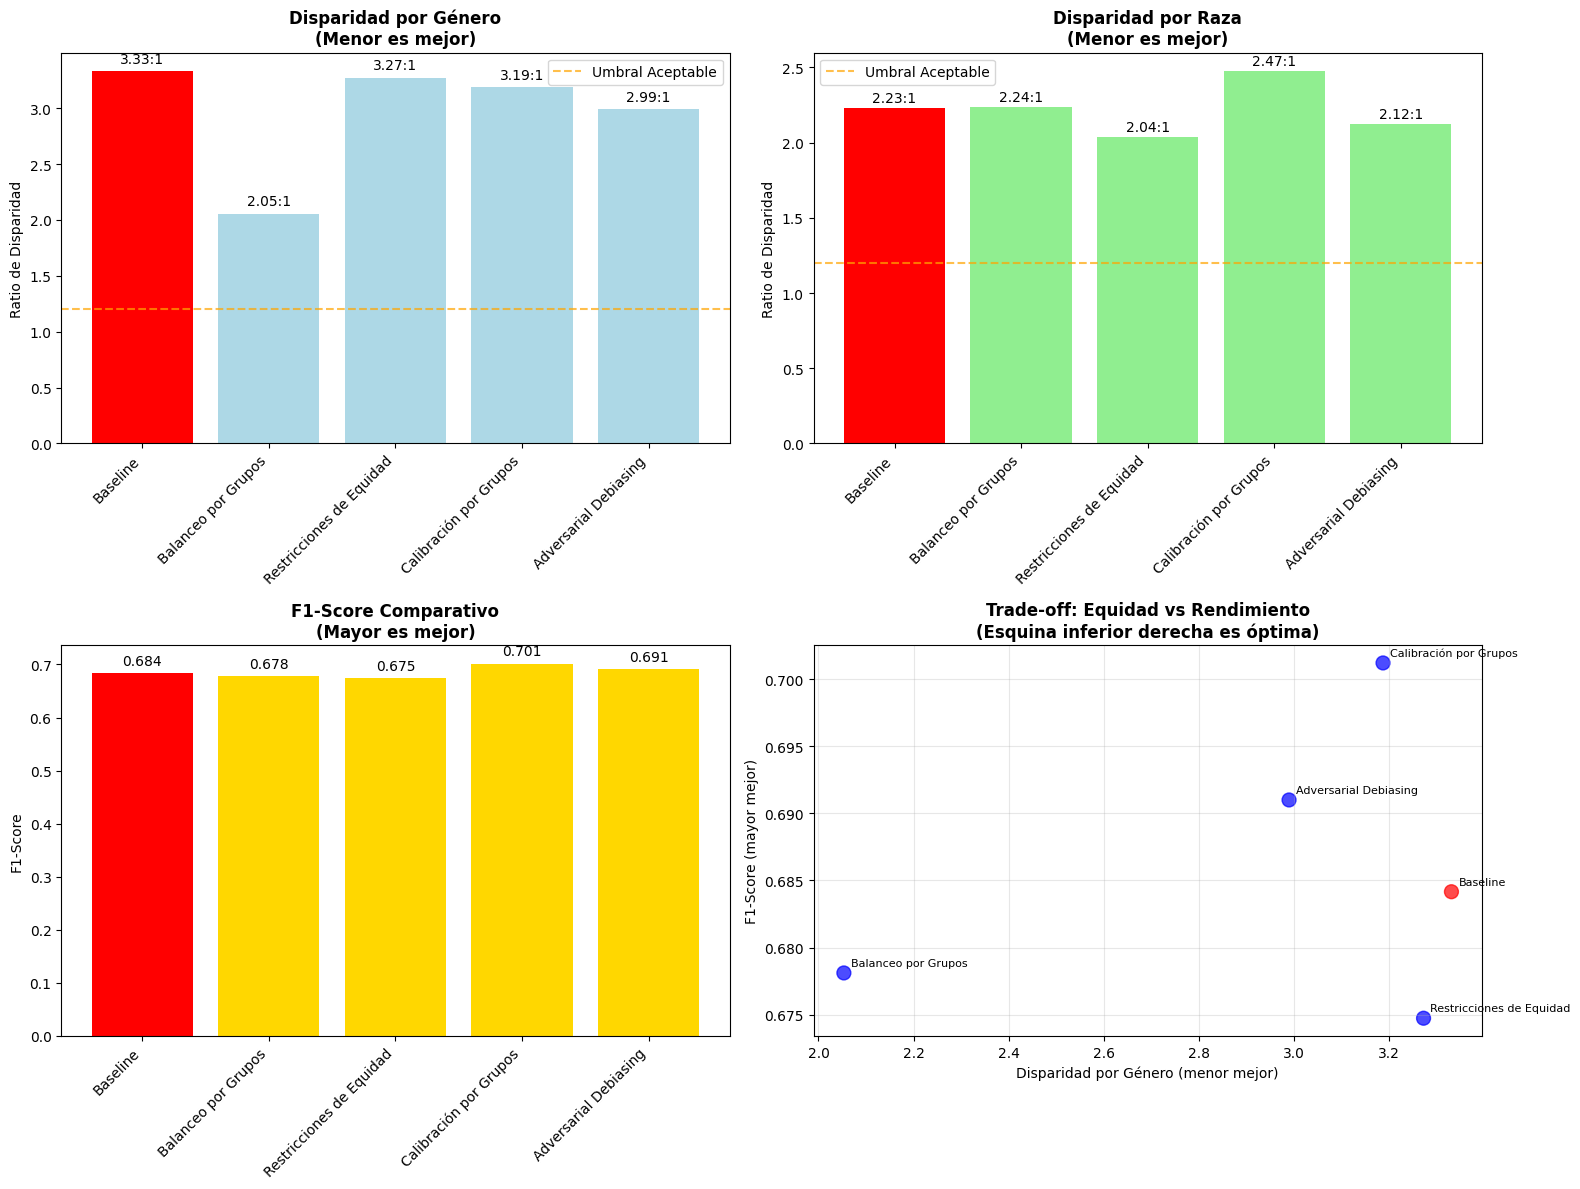


💾 Guardando resultados de mitigación en mitigation_results_comparison.json...
✅ Resultados guardados en mitigation_results_comparison.json


In [23]:
mitigation_system.visualize_bias_comparison()

In [24]:
final_summary = mitigation_system.generate_final_report()


📋 REPORTE FINAL: MITIGACIÓN DE SESGOS ALGORÍTMICOS
🏆 MEJORES MODELOS POR CATEGORÍA:
   Equidad (menor sesgo): group_balanced
   Rendimiento (mayor F1): calibrated
   Balance general: group_balanced

💡 RECOMENDACIONES:
   ✅ Usar modelo: Balanceo por Grupos
   📊 F1-Score: 0.6781
   🎯 Mejora sesgo género: +38.4%
   🎯 Mejora sesgo raza: -0.2%

⚠️ CONSIDERACIONES DE IMPLEMENTACIÓN:
   1. Monitoreo continuo de métricas de equidad en producción
   2. Re-evaluación periódica con datos más recientes
   3. Validación con stakeholders de grupos afectados
   4. Documentación transparente de limitaciones
